In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect (host = "localhost",
                              username = "root",
                              password = "Pranit1234",
                              database = "ecommerce")
cur = db.cursor()

In [52]:
#List all unique cities where customers are located.

query = """select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [21]:
# Count the number of orders placed in 2017.

query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

"Total orders placed in 2017 are ",data[0][0]

('Total orders placed in 2017 are ', 45101)

In [24]:
# Find the total sales per category.

query = """select products.product_category category, round(sum(payments.payment_value),2) sales
           from products join order_items
           on products.product_id = order_items.product_id
           join payments
           on payments.order_id = order_items.order_id
           group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["category","sales"])

df

,category,sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


In [33]:
# Calculate the percentage of orders that were paid in installments.

query = """select (sum(case when payment_installments > 0 then 1 else 0 end))/count(*)*100 from payments"""

cur.execute(query)

data = cur.fetchall()

"The percentage of orders that were paid in installments is", data[0][0]

('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

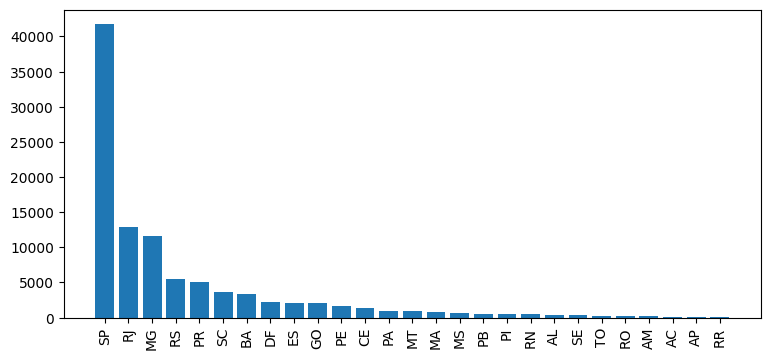

In [51]:
# Count the number of customers from each state.

query = """select customer_state,count(customer_id) from customers group by customer_state"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame (data, columns = ["State","Cust_count"])
df = df.sort_values(by = "Cust_count", ascending = False)

plt.figure(figsize = (9,4))
plt.bar(df["State"], df["Cust_count"])
plt.xticks(rotation = 90)
plt.show()

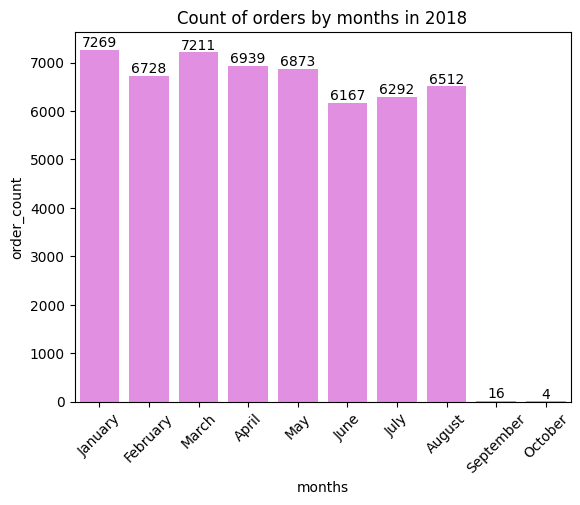

In [69]:
# Calculate the number of orders per month in 2018.

query = """select monthname(order_purchase_timestamp) months, count(order_id) order_count
           from orders
           where year(order_purchase_timestamp) = 2018
           group by months"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["months","order_count"])
o = ["January","February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"], y = df["order_count"], data = df, order = o, color = "violet")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of orders by months in 2018")

plt.show()

In [77]:
# Find the average number of products per order, grouped by customer city

query = """select customers.customer_city,round(avg(count_per_order.OI),2) average_orders from
           (select orders.order_id,orders.customer_id,count(order_items.order_id) AS OI
           from ecommerce.orders
           join ecommerce.order_items
           on orders.order_id = order_items.order_id
           group by orders.order_id, orders.customer_id) as count_per_order
           join ecommerce.customers
           on customers.customer_id = count_per_order.customer_id
           group by customers.customer_city order by average_orders"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["customer_city","average_per_orders"])

df.head(10)

,customer_city,average_per_orders
0,cacaulandia,1.00
1,teresina de goias,1.00
2,santa maria do herval,1.00
3,patrocinio paulista,1.00
4,lagoa d'anta,1.00
5,panelas,1.00
6,caridade,1.00
7,erebango,1.00
8,botupora,1.00
9,nova esperanca do sudoeste,1.00


In [81]:
# Calculate the percentage of total revenue contributed by each product category

query = """select products.product_category category,
           round((sum(payments.payment_value) / (select sum(payment_value) from ecommerce.payments))*100,2) sales_percentage
           from ecommerce.products join ecommerce.order_items
           on products.product_id = order_items.product_id
           join ecommerce.payments
           on payments.order_id = order_items.order_id
           group by category
           order by sales_percentage"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["category","sales_percentage"])

df.head(10)

,category,sales_percentage
0,insurance and services,0.00
1,Fashion Children's Clothing,0.00
2,Arts and Crafts,0.01
3,flowers,0.01
4,PC Gamer,0.01
5,cds music dvds,0.01
6,House Comfort 2,0.01
7,La Cuisine,0.02
8,Fashion Sport,0.02
9,Fashion Women's Clothing,0.03


In [89]:
# Identify the correlation between product price and the number of times a product has been purchased

query = """select products.product_category as CATEGORY, count(order_items.product_id) as COUNT_OF_ORDERS, round(avg(order_items.price),2) as PRICE
           from ecommerce.products
           join ecommerce.order_items
           on products.product_id = order_items.product_id
           group by products.product_category"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["CATEGORY","COUNT_OF_ORDERS","PRICE"])

arr1 = df["COUNT_OF_ORDERS"]
arr2 = df["PRICE"]

a = np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchased is ", a[0][-1])

The correlation between product price and the number of times a product has been purchased is  -0.10631514167157567


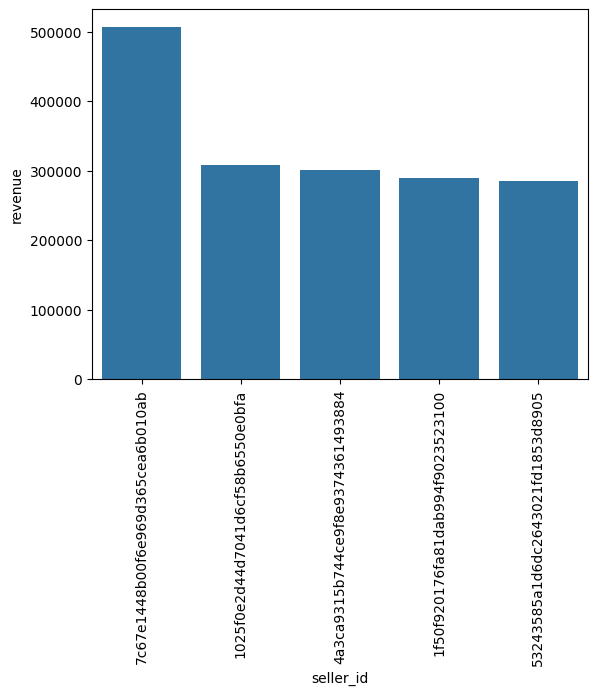

In [102]:
# Calculate the total revenue generated by each seller, and rank them by revenue

query = """select *, dense_rank() over(order by revenue desc) as RN from
           (select order_items.seller_id, sum(payments.payment_value) as revenue
           from order_items
           join payments
           on order_items.order_id = payments.order_id
           group by order_items.seller_id) as a"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id","revenue","rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

In [107]:
# Calculate the moving average of order values for each customer over their order history.

query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as Moving_AVG
from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
from ecommerce.orders
join ecommerce.payments
on orders.order_id = payments.order_id) A"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_id","order_purchase_timestamp","payment","Moving_AVG"])
df.head(10)

,customer_id,order_purchase_timestamp,payment,Moving_AVG
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.709961


In [113]:
# Calculate the cumulative sales per month for each year.

query = """select A.YEAR, A.MONTH, A.payment,sum(A.payment) over (order by YEAR, MONTH) as Cumulative_sales
from
(SELECT year(orders.order_purchase_timestamp) as YEAR,
month(orders.order_purchase_timestamp)as MONTH, round(sum(payments.payment_value), 2) as payment
FROM ecommerce.orders
join ecommerce.payments
on orders.order_id = payments.order_id
group by YEAR, MONTH order by YEAR, MONTH) as A"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


In [119]:
# Calculate the year-over-year growth rate of total sales.

query = """select A.YEAR, ((A.payment - lag(A.payment, 1) over(order by A.YEAR)) / lag(A.payment, 1) over(order by A.YEAR)) * 100 Previous_Year
from
(SELECT year(orders.order_purchase_timestamp) as YEAR, round(sum(payments.payment_value), 2) as payment
FROM ecommerce.orders
join ecommerce.payments
on orders.order_id = payments.order_id
group by YEAR order by YEAR) as A"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["YEAR", "YOY % Growth"])
df

,YEAR,YOY % Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


In [120]:
# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

query = """select A.customer_id, count(distinct orders.order_purchase_timestamp)
from
(select customers.customer_id, min(orders.order_purchase_timestamp) as first_order
FROM ecommerce.customers
join ecommerce.orders
on customers.customer_id = orders.customer_id
group by customers.customer_id) as A
join ecommerce.orders
on orders.customer_id = A.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by A.customer_id"""

cur.execute(query)

data = cur.fetchall()
data
# Output is blank bcuz of there is no customer who purchase within 6 months of their first purchase.

[]

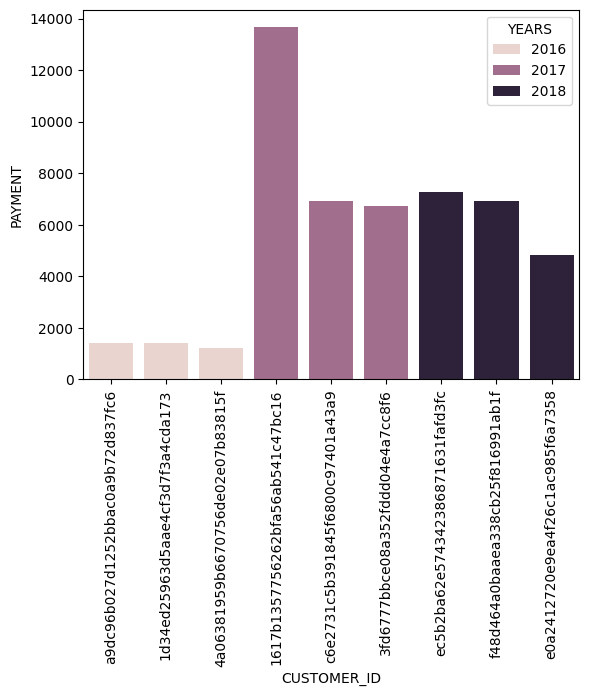

In [124]:
# Identify the top 3 customers who spent the most money in each year.

query = """select year, customer_id, payment, d_rank
from
(select year(order_purchase_timestamp) as year, orders.customer_id, sum(payments.payment_value) as payment,
dense_rank() over(partition by year(order_purchase_timestamp)  order by sum(payments.payment_value) desc) as d_rank
from ecommerce.orders
join ecommerce.payments
on orders.order_id = payments.order_id
group by year(order_purchase_timestamp), orders.customer_id) as A where d_rank <= 3"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["YEARS","CUSTOMER_ID","PAYMENT","RANK"])

sns.barplot(x = "CUSTOMER_ID", y = "PAYMENT", data = df, hue = "YEARS")
plt.xticks(rotation = 90)
plt.show()